In [1]:
import scipy
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import os
from utils import *
from tdoa_sync import gcc_phat, calculate_lag_and_align
from tqdm import tqdm
from pulse_detection import *
from continuous_detection import *
from visualization import *
from combined_detection import *



In [2]:
# Path configurations
cd = os.getcwd().replace('\\','/')
paths = {}
paths['root'] = cd
paths['data'] = os.path.join(paths['root'], 'data')
paths['data_sim_ricker'] = os.path.join(paths['data'], 'simulation_ricker.mat')
paths['data_sim_cont'] = os.path.join(paths['data'], 'simulation_continuous.mat')
paths['data_sim_multi'] = os.path.join(paths['data'], 'simulation_multisource.mat')

# Q1


In this part we use the Teager-Kaiser energy operator (TKEO) for a measure of the instantaneous enregy in the signal.\
The TKEO is defined as:\
\
y_{t} = x_{t} ^ 2 - x_{t-1} * x_{t+1} . 
\
\
It is commonly used in applications such as EEG or speech analysis where detection of sharp transitions is required, and is therefore useful in our case as we excpect a sharp transition due to the pulse-like nature of the measured signal.


In the following blocks we demonstrate how it works on a single signal:

Text(0.5, 1.0, 'Signal')

<Figure size 640x480 with 0 Axes>

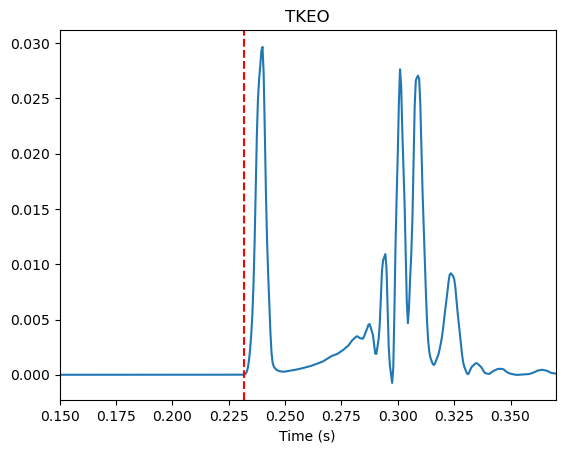

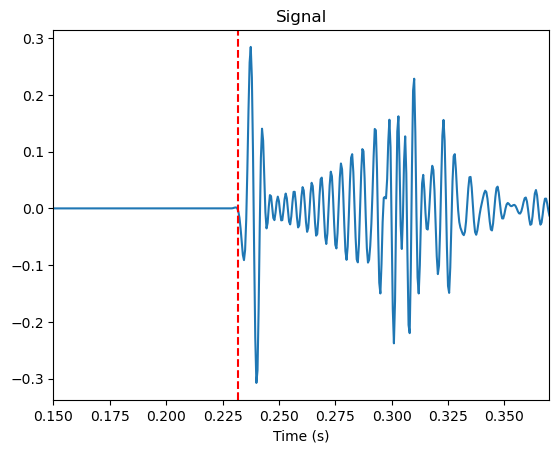

In [3]:
# Load data
data, fs, geometry = load_data(paths['data_sim_ricker'])
n_sensors, n_samples = data.shape

# Normalize the multi-channeled data using the max value
normalization_fac = np.abs(data).max()
data_norm = data / normalization_fac

sig1 = data_norm[[59], :]
t_vec = np.arange(0, n_samples)/fs

# Zoomed-in example:
# Plot the onset for the reference signal:
onset_times, onset_indices = find_earliest_occurrences_with_tkeo_impulse(sig1, fs, peak_thresh_dB=30)

plt.figure()
plot_tkeo(sig1[0,:], t_vec)
plt.axvline(onset_indices[0]/fs, color='r', linestyle='--')
plt.xlim([0.15,0.37])
plt.xlabel("Time (s)")
plt.title("TKEO")


plt.figure()
plt.plot(t_vec, sig1[0,:])
# plt.plot(np.arange(0, n_samples), data[0,:])
# plt.axvline(onset_indices[0], color='r', linestyle='--')
plt.axvline(onset_indices[0] / fs, color='r', linestyle='--')
plt.xlim([0.15,0.37])
plt.xlabel("Time (s)")
plt.title("Signal")

In this part, our goal is to callibrate all signals into a single reference time axis. This would allow us to perform picking of a single time across all sensors synchroniously.\
We will define a reference sensor whos time-axis we use as a reference. We can calculate the lag between each sensor and the reference sensor using correlation on the measured signals. This calibration will enable to perform statistical analysis on the predicted onsets in the shared reference time axis, giving a better estimate for the time we should pick. After the time is picked, it is shifted back to every orignal time channel.
\
\
In the following blocks we demonstrate how the calibration is done. We then use it together with the TKEO-based detection algorithm to pick a joint onset and calibrate it across all signals.


 lag_vec=[-17. -18. -21. -24. -27. -29. -32. -33. -36. -38. -40. -42. -44. -45.
 -47. -48. -50. -51. -53. -53. -54. -55. -56. -57. -57. -57. -58. -58.
 -57. -57. -57. -56. -56. -55. -54. -53. -51. -51. -49. -47. -46. -44.
 -42. -41. -38. -36. -34. -32. -29. -28. -25. -22. -19. -17. -14. -12.
  -9.  -6.  -3.   0.   4.   6.  10.  14.]
 onset_indices=[453, 451, 449, 446, 444, 441, 439, 437, 435, 433, 431, 429, 427, 425, 424, 422, 421, 419, 418, 417, 416, 415, 415, 414, 414, 414, 413, 413, 413, 414, 414, 415, 415, 416, 417, 418, 419, 420, 422, 423, 425, 427, 429, 430, 432, 434, 436, 439, 441, 443, 445, 448, 450, 453, 456, 458, 461, 464, 467, 470, 474, 478, 482, 490]


Text(0.5, 1.0, 'Predicted Onsets from 64 Channels\n (On the Reference Time-Axis)')

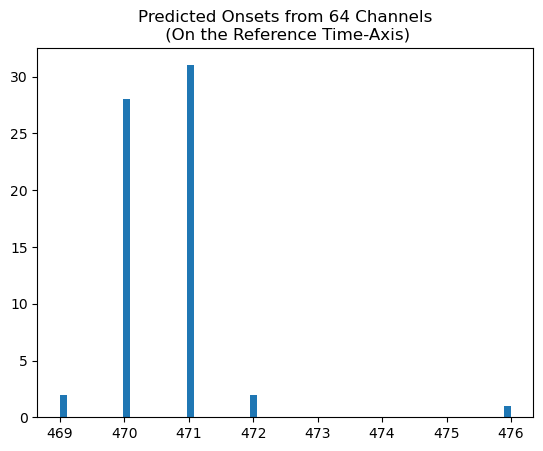

In [4]:

# Setting the reference signal sig1:
sig1 = data_norm[59]

# Calculate lag using regular correlation:
lag_vec = np.zeros(n_sensors)
for i in range(n_sensors):
    sig2 = data_norm[i]
    _, _, lag_samples, lag_time = calculate_lag_and_align(sig=sig2, refsig=sig1, fs=fs, do_visualize=False)
    lag_vec[i] = lag_samples

print(f" lag_vec={ lag_vec}")

# Find onsets with tkeo
onset_times, onset_indices = find_earliest_occurrences_with_tkeo_impulse(data_norm, fs, peak_thresh_dB=10)
print(f" onset_indices={ onset_indices}")

normalized_indices = np.array(onset_indices) - lag_vec

# Plot histogram of the onsets of all sensors (reference time-axis)
plt.figure()
_ = plt.hist(normalized_indices, bins=64)
plt.title('Predicted Onsets from 64 Channels\n (On the Reference Time-Axis)')



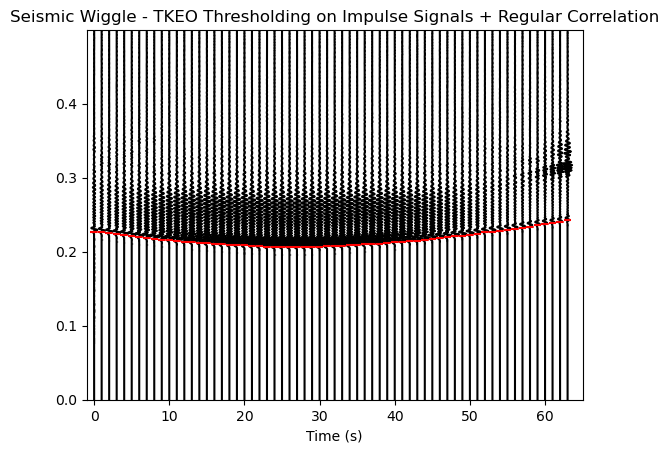

In [5]:
# Pick the onset using median on all estimated onsets (in the reference time-axis):
picked_idx_reference = np.median(normalized_indices)

# Return to each signal's original time-axis
picked_indices = picked_idx_reference + lag_vec

# Plot a seismic wiggle figure with the synchroniously picked onsets:


title = 'Seismic Wiggle - TKEO Thresholding on Impulse Signals + Regular Correlation'
fig = seismic_wiggle(data_norm, t_vec, picked_indices=picked_indices, title=title)


# Q2

### Demonstration:
In the following two blocks we show that calibration using cross-correlation similarly to before, together with the TKEO-based algorithm for detection - don't work for the new type of signals.


lag_vec_cont=[-3. -6.  3.  0. -3. -5. -8.  1. -2. -4. -6. -8.  1. -1. -2. -4. -5. -6.
 -8. -9.  2.  1.  0.  0.  0.  0.  0.  0.  0.  1.  2. -9. -8. -6. -5. -4.
 -2. -1.  1. -8. -6. -4. -2.  1. -8. -5. -3.  0.  3. -6. -3.  0.  3.  6.
 -2.  0. -8. -5. -3.  0.  3. -5. -1.  4.]


Text(0.5, 1.0, 'Onsets Predicted on 64 Channels\n (Reference Time-Axis)')

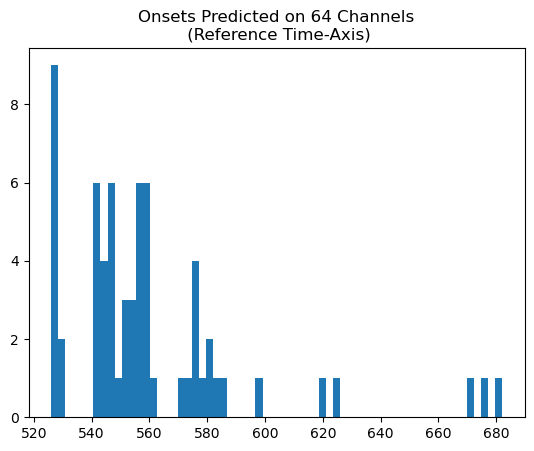

In [6]:
data, fs, geometry = load_data(paths['data_sim_cont'])
data.shape
geometry.shape
n_sensors, n_samples = data.shape

normalization_fac = np.abs(data).max()
data_norm = data / normalization_fac

# # Setting the reference signal sig1:
sig1 = data_norm[59]

# Calculate lag using regular correlation:
lag_vec_cont = np.zeros(n_sensors)
for i in range(n_sensors):
    sig2 = data_norm[i]
    _, _, lag_samples, lag_time = calculate_lag_and_align(sig=sig2, refsig=sig1, fs=fs, do_visualize=False)
    lag_vec_cont[i] = lag_samples

print(f"lag_vec_cont={lag_vec_cont}")


# Find onsets with tkeo
onset_times, onset_indices = find_earliest_occurrences_with_tkeo_impulse(data_norm, fs, peak_thresh_dB=20)

normalized_indices = np.array(onset_indices) - lag_vec_cont

# Plot histogram of the onsets of all sensors (reference time-axis)
plt.figure()
_ = plt.hist(normalized_indices, bins=64)
plt.title('Onsets Predicted on 64 Channels\n (Reference Time-Axis)')



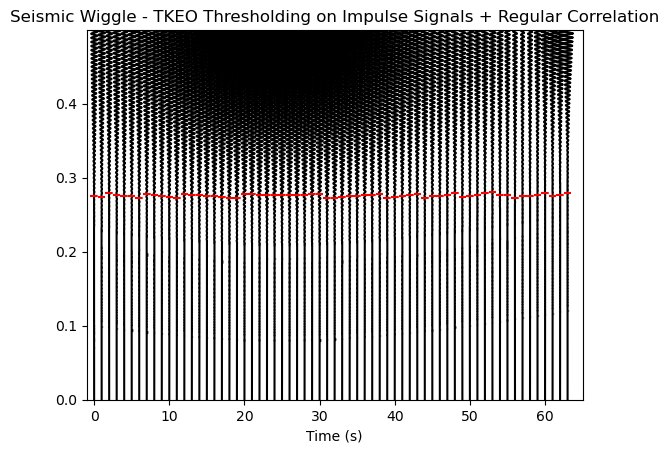

In [7]:
# Pick the onset using median on all estimated onsets (in the reference time-axis):
picked_idx_reference = np.median(normalized_indices)

# Return to each signal's original time-axis
picked_indices = picked_idx_reference + lag_vec_cont

# Plot a seismic wiggle figure with the synchroniously picked onsets:

t_vec = np.arange(0, n_samples)/fs
title = 'Seismic Wiggle - TKEO Thresholding on Impulse Signals + Regular Correlation'
fig = seismic_wiggle(data_norm, t_vec, picked_indices=picked_indices, title=title)


From the above histogram of predicted onsets, which is way too-spread, and from comparing the new lag_vector to the previous lag_vector we learn that cross-correlation between the signals is not ideal for calibration.

##### A note on the calibration process - 
A common method for the task is the GCC-PHAT which involves computation of the generalized cross-correlation from the attenuated cross-spectrum. While it is generally a good method, it fails badly when the cross-spectrum is narrow (such as in our case).\
Having numerous failed attempts of calibration of these narrowband signals, I chose to leave this part aside in order to focus on the other parts of the excercise.\
From now on I assume that the source hasn't moved and only changes its produced signals. That would enable
the use the lag_vector for all that was calculated from the impulse signals in Q1. Essentially, the result from Q1 could be thought of as a calibration process for TDOA synchronization (a process that commonly involves impulse signals).


##### Problems with using TKEO based picking on continuous signals:
As visible in the next block, the TKEO based algorithm misses on a quite large portion of the signal beginning. We should consider another approach.


Text(0.5, 1.0, 'Clean Signal')

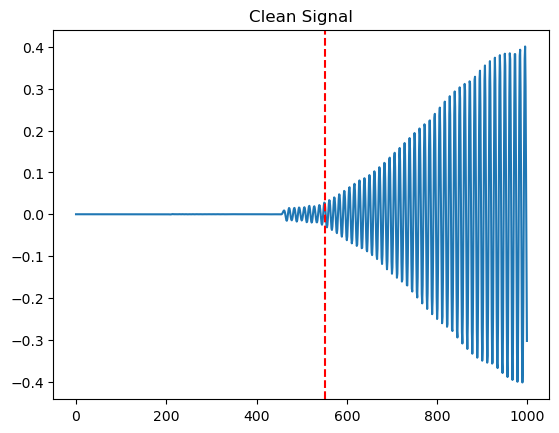

In [8]:
ch = 0
plt.figure()
plt.plot(data_norm[ch,:])
plt.axvline(picked_indices[ch], color='r', linestyle='--')
plt.title(f"Clean Signal")



# The new approach - STFT Energy Thresholding:
Since we know that the signals are made of a sinusoidal with a slowly increasing amplitude, we can use that for our advantage and work in the frequency domain.\
We will perform short-frame based analysis of the original signal, and calculate the its energy spectrum. Since we know that there is a dominant frequency, we are guaranteed that at some point, once the frame includes the beginning of the occurence, a peak will rise at this frequency in the energy spectrum.
To detect such rise in frequency, we will compare each frequency to its floor noise level.\
To find the floor noise, we first pad the beginning of each signal with baseline, which would basically be a region that contains only noise and is only used for floor noise estimation.\
In addition, to make sure we don't false accept a frequency in cases where there is no noise floor (clean signal, for example), we compare the energy_per_sample of the suspected frequency in the STFT frame with its counterpart in the FFT (of the entire signal). We demand that the former should be at least factor * the latter.


In the following box we visualize the algorithm's performance on a single measured signal, showing how it deals with different SNR values for white gaussian noise (WGN).

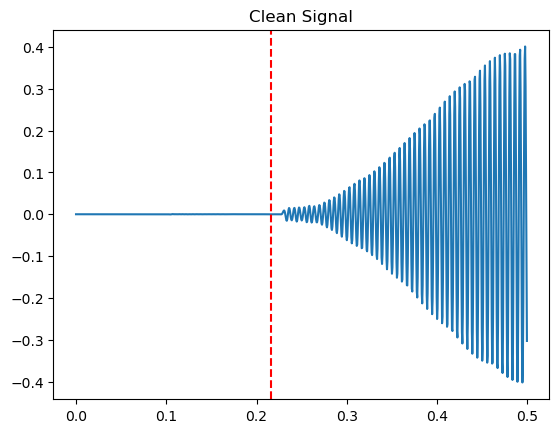

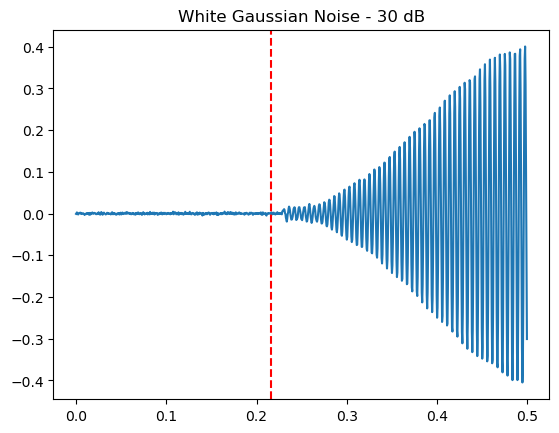

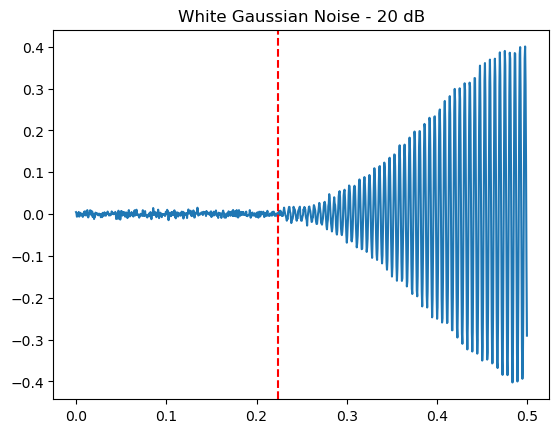

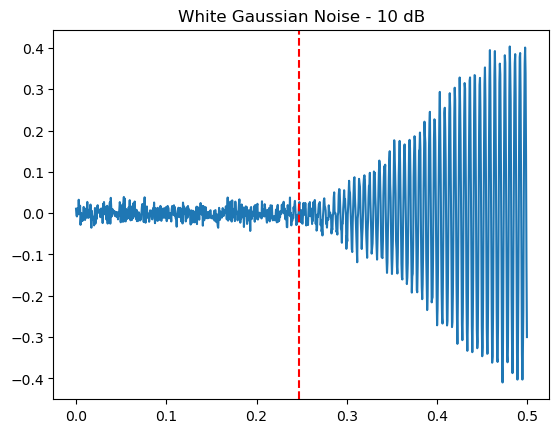

In [9]:
# Extend the signals - pad their beginning with noise, for noise-floor estimation:
extend_duration  = 3 # seconds

data_extended, t_vec_new, baseline_samples, baseline_indices =\
prep_baseline(data_norm, fs ,extend_duration=extend_duration)

# Plot multiple SNR values
snr_list = [None,30,20,10]  # dB
for snr_dB in snr_list:
    # Samples used for noise-floor estimation

    if snr_dB is None:
        noisy_data = data_extended
    else:
        noisy_data = add_noise(data_extended, snr_dB=snr_dB, fs=fs, noise_type='WGN')

    # Visualizing a single sensor for now:
    i = 0
    sig = noisy_data[i,:]

    onset_bin_idx, onset_time = find_earliest_occurrences_stft_energy_thresh(sig, fs, baseline_indices, window='hann',
                                                    window_sz=128, frame_jump=16, peak_thresh_dB=60, noise_floor_factor=20)

    # Plot
    title = "Clean Signal" if snr_dB is None else f"White Gaussian Noise - {snr_dB} dB"
    onset_idx_original = int(onset_time * fs)
    plt.figure()
    plt.plot(t_vec,sig[extend_duration*fs:])
    plt.axvline(onset_idx_original/fs, color='r', linestyle='--')
    plt.title(title)


We now apply it on all channels, following the same methodology from before (picking the median predicted time on the reference time-axis). We first calculate the ground truths using the clean signals and then compare them to the picked times at the noisy signals.

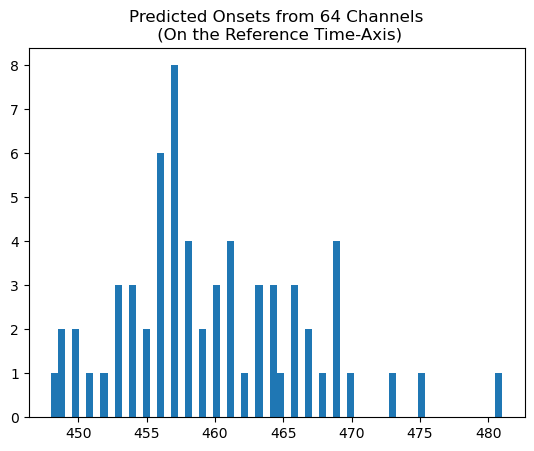

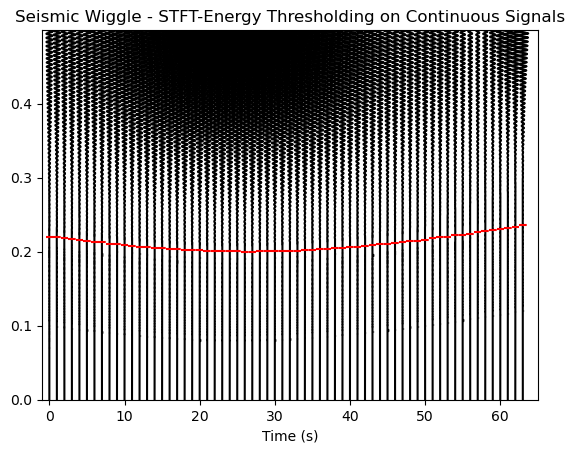

In [10]:
# Find the ground truths:

clean_data, t_vec_new, baseline_samples, baseline_indices =\
prep_baseline(data_norm, fs ,extend_duration=3)

stft_thresh_params = dict(data=clean_data, fs=fs, baseline_indices=baseline_indices,
                           window='hann', window_sz=128, frame_jump=16,
                           peak_thresh_dB=60, noise_floor_factor=20)
        
onset_times, onset_indices = early_occurences_stft_multichannel(**stft_thresh_params)

ground_truths = onset_times 

normalized_indices = np.array(onset_indices) - lag_vec

# Plot histogram of the onsets of all sensors (reference time-axis)
plt.figure()
_ = plt.hist(normalized_indices, bins=64)
plt.title('Predicted Onsets from 64 Channels\n (On the Reference Time-Axis)')

# Pick the onset using median on all estimated onsets (in the reference time-axis):
picked_idx_reference = np.median(normalized_indices)

# Return to each signal's original time-axis
picked_indices = picked_idx_reference + lag_vec

# Plot a seismic wiggle figure with the synchroniously picked onsets:
title = 'Seismic Wiggle - STFT-Energy Thresholding on Continuous Signals'
fig = seismic_wiggle(data_norm, t_vec, picked_indices=picked_indices, title=title)



Looking at the seismogram above, the red "picking" line seems to match the the time that was picked in the previous visualization (~0.22 ms) of trace 0.

In [11]:
def calc_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

picked_times = np.array([id/fs for id in picked_indices])
print(f"Clean Signals RMSE = {calc_rmse(picked_times, ground_truths) * 1000:.2f} ms")


Clean Signals RMSE = 3.60 ms


Note that the RMSE is not 0 for the clean signals because actually pick a synchronized time between all sensors, and don't pick the preicted onset of each signal.



# Q3.
We now move on to plotting the RMSE vs the SNR for each noise type.\
We do that for each signal type and its corresponding detection method.


#### Starting with the continuous signals:

Noise Type: WGN,  SNR: 30dB,  RMSE: 3.77 ms
Noise Type: WGN,  SNR: 25dB,  RMSE: 3.46 ms
Noise Type: WGN,  SNR: 20dB,  RMSE: 7.35 ms
Noise Type: WGN,  SNR: 15dB,  RMSE: 14.65 ms
Noise Type: WGN,  SNR: 10dB,  RMSE: 30.68 ms
Noise Type: Pink,  SNR: 30dB,  RMSE: 3.77 ms
Noise Type: Pink,  SNR: 25dB,  RMSE: 3.77 ms
Noise Type: Pink,  SNR: 20dB,  RMSE: 5.86 ms
Noise Type: Pink,  SNR: 15dB,  RMSE: 12.95 ms
Noise Type: Pink,  SNR: 10dB,  RMSE: 22.75 ms


Text(0.5, 1.0, 'RMSE vs SNR - Continuous Signals')

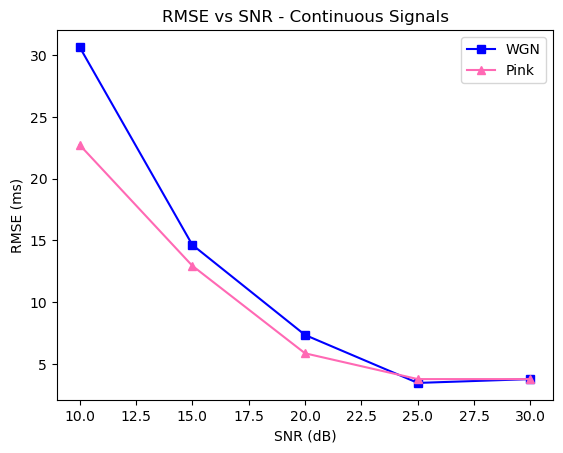

In [12]:
# Performance analysis for continuous signals (RMSE vs SNR)
snr_dB_list = [30, 25, 20, 15, 10]
noise_type_list = ['WGN', 'Pink']

rmse_dict = {}
for noise_type in noise_type_list:
    rmse_dict[noise_type] = []

    for snr_dB in snr_dB_list:
        noisy = add_noise(data_extended, snr_dB=snr_dB, fs=fs, noise_type=noise_type)

        # get predictions for the early occurences across al sensors
        stft_thresh_params = dict(data=noisy, fs=fs, baseline_indices=baseline_indices,
                                window='hann', window_sz=128, frame_jump=16,
                                peak_thresh_dB=60, noise_floor_factor=20)
        onset_times, onset_indices = early_occurences_stft_multichannel(**stft_thresh_params)

        # Shift the time indices to the joint reference time-axis
        normalized_indices = np.array(onset_indices) - lag_vec
        # Pick the onset using median on all estimated onsets (in the reference time-axis):
        picked_idx_reference = np.median(normalized_indices)

        # Return to each signal's original time-axis
        picked_indices = picked_idx_reference + lag_vec


        picked_times = np.array([id/fs for id in picked_indices])
        rmse = calc_rmse(picked_times, ground_truths)
        print(f"Noise Type: {noise_type},  SNR: {snr_dB}dB,  RMSE: {rmse * 1000:.2f} ms")

        rmse_dict[noise_type].append(rmse)


plt.figure()
plt.plot(snr_dB_list, np.array(rmse_dict['WGN']) * 1000, 'bs-')
plt.plot(snr_dB_list, np.array(rmse_dict['Pink']) * 1000, '^-', color='hotpink')
plt.legend(['WGN', 'Pink'])
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (ms)")
plt.title("RMSE vs SNR - Continuous Signals")




#### Moving on to the pulse signals:

In [13]:
# Load data
data, fs, geometry = load_data(paths['data_sim_ricker'])
n_sensors, n_samples = data.shape

# Normalize the multi-channeled data using the max value
normalization_fac = np.abs(data).max()
data_norm = data / normalization_fac
data_clean = data_norm

t_vec = np.arange(0, n_samples)/fs

# Get ground truths first:
onset_times, onset_indices = find_earliest_occurrences_with_tkeo_impulse(data_clean, fs, peak_thresh_dB=20)

# Ground truths are received by the clean signals.
ground_truths = onset_times 

Noise Type: WGN,  SNR: 30dB,  RMSE: 1.88 ms
Noise Type: WGN,  SNR: 25dB,  RMSE: 1.88 ms
Noise Type: WGN,  SNR: 20dB,  RMSE: 1.39 ms
Noise Type: WGN,  SNR: 15dB,  RMSE: 1.39 ms
Noise Type: WGN,  SNR: 10dB,  RMSE: 1.39 ms
Noise Type: WGN,  SNR: 5dB,  RMSE: 101.39 ms
Noise Type: Pink,  SNR: 30dB,  RMSE: 1.63 ms
Noise Type: Pink,  SNR: 25dB,  RMSE: 1.88 ms
Noise Type: Pink,  SNR: 20dB,  RMSE: 1.88 ms
Noise Type: Pink,  SNR: 15dB,  RMSE: 1.39 ms
Noise Type: Pink,  SNR: 10dB,  RMSE: 1.39 ms
Noise Type: Pink,  SNR: 5dB,  RMSE: 1.39 ms


Text(0.5, 1.0, 'RMSE vs SNR - Continuous Signals')

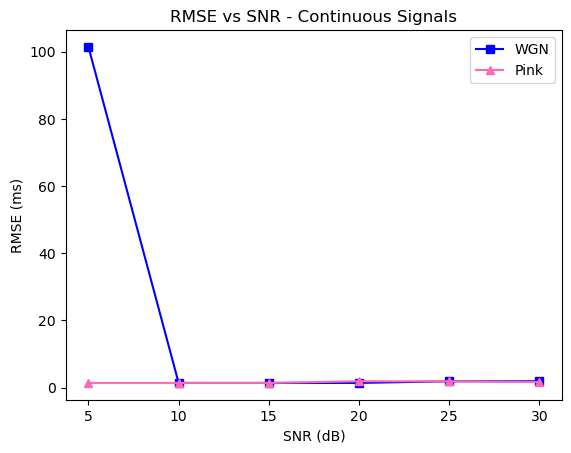

In [14]:
# Performance analysis for pulse signals (RMSE vs SNR)
snr_dB_list = [30, 25, 20, 15, 10,5]
noise_type_list = ['WGN', 'Pink']

rmse_dict = {}
for noise_type in noise_type_list:
    rmse_dict[noise_type] = []

    for snr_dB in snr_dB_list:
        noisy = add_noise(data_norm, snr_dB=snr_dB, fs=fs, noise_type=noise_type)

        # get predictions for the onsets across all sensors
        onset_times, onset_indices  = find_earliest_occurrences_with_tkeo_impulse(noisy, fs, peak_thresh_dB=10)

        # Shift the time indices to the joint reference time-axis
        normalized_indices = np.array(onset_indices) - lag_vec
        # Pick the onset using median on all estimated onsets (in the reference time-axis):
        picked_idx_reference = np.median(normalized_indices)

        # Return to each signal's original time-axis
        picked_indices = picked_idx_reference + lag_vec


        picked_times = np.array([id/fs for id in picked_indices])
        rmse = calc_rmse(picked_times, ground_truths)
        print(f"Noise Type: {noise_type},  SNR: {snr_dB}dB,  RMSE: {rmse * 1000:.2f} ms")

        rmse_dict[noise_type].append(rmse)


plt.figure()
plt.plot(snr_dB_list, np.array(rmse_dict['WGN']) * 1000, 'bs-')
plt.plot(snr_dB_list, np.array(rmse_dict['Pink']) * 1000, '^-', color='hotpink')
plt.legend(['WGN', 'Pink'])
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (ms)")
plt.title("RMSE vs SNR - Continuous Signals")


#### Discussion
Inspecting the above plot might be misleading if we look for a trend. In fact, we see that the algorithm achieves very good results in terms of RMSE across almost all of the examined SNR levels.
Notably, it starts breaking for SNR <= 5, as the energy of the noise starts to cover that of the impulse, and the tkeo-threshold can no longer differentiate between noise and real peaks.

# Q4
A major problem I noticed when I inspected the more complex dataset was that some signals showed different properties from other signals. This resulted in a varying amount of pulses detected for different sensors, while playing with the sensitivity of the detection couldn't improve one sensor without ruining the performance of another. (This concludes many attempts I tried to manually detect pulse peaks with various approaches)

Instead, I've decided to approach the problem from a more statistical point of view.
Here, I make use of the fact that the sensors are synchronized (up to a lag) and that they record the same signal. This means that we can detect the onsets in each sensor, and if any sensor missed an occurrence - it would still be fine, since we know that some other sensors detected an occurrence there.

Since many sensors miss occurrence detections, the key point in this approach is to understand how many occurrences there are, and then to locate them.\
To do that, we first detect all onsets from all sensors (using the methods from the previous questions). We can shift these onsets to the reference time-axis where we can statistically process them in the same domain. Then, we fit a Gaussian Mixture Model (GMM) on the onsets do determine how many occurrences there are (the number of gaussians - determined using ELBOW method), and then classify the onsets to these different classes. We take the median of each class to get its onset prediction.\
Eventually, we shift the onsets back to their original time axis and show this on a seismogram.



In [15]:
# Load the multisource problem:
data, fs, geometry = load_data(paths['data_sim_multi'])
n_sensors, n_samples = data.shape

# Normalize the multi-channeled data using the max value
normalization_fac = np.abs(data).max()
data_norm = data / normalization_fac

# sig1 = data_norm[[59], :]
t_vec = np.arange(0, n_samples)/fs

extend_duration = 3
timeshift = extend_duration * fs

clean_data, t_vec_new, baseline_samples, baseline_indices =\
prep_baseline(data_norm, fs ,extend_duration=extend_duration)

Text(0.5, 1.0, 'Onsets Histogram')

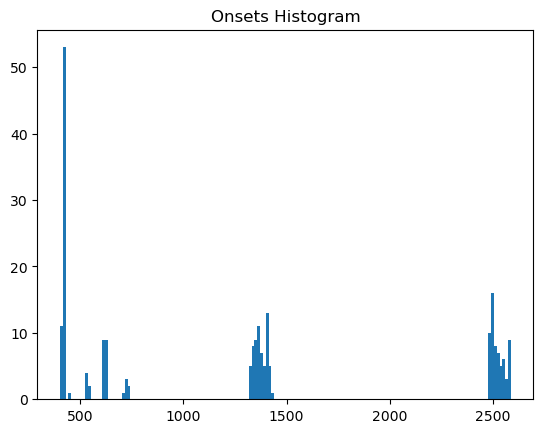

In [16]:
# Predict onsets using the
occurence_times_cont, occurence_indices_cont =\
      all_early_occurences_stft_multichannel(
        clean_data, fs, baseline_indices, window='hann', window_sz=128,
          frame_jump=16, peak_thresh_dB=30, noise_floor_factor=20)

occurence_times_pulse, occurence_indices_pulse =\
      find_all_occurrences_with_tkeo_impulse(clean_data, fs, peak_thresh_dB=20)


# Combine the detections from both algorithms:
filtered_pulse_onsets = {}
filtered_cont_onsets = {}
detected_onsets = {}
detected_onsets_reference_timeax = {}
for i in range(n_sensors):
    filtered_pulse_onsets[i] = filter_occurence_indices(occurence_indices_pulse[i], min_space=80)
    _, connected_components_cont = get_connected_components(occurence_indices_cont[i])

    # If an onset detected by the pulse method is contained within a component that was detected
    #  by the continuous method - we keep the onset detected by the continuous method
    detected_onsets[i] = []
    detected_onsets_reference_timeax[i] = []
    for pulse_onset in filtered_pulse_onsets[i]:
        if not any([pulse_onset in range(a,b) for (a,b) in connected_components_cont]):
            onset_kept = pulse_onset - timeshift
        else:
            comp_id = np.where([pulse_onset in range(a,b) for (a,b) in connected_components_cont])[0].item()
            onset_kept = connected_components_cont[comp_id][0] - timeshift
        
        detected_onsets[i].append(onset_kept)
        detected_onsets_reference_timeax[i].append(onset_kept - lag_vec[i])


# Concatenated onsets:
conc_onsets = []
for val in detected_onsets_reference_timeax.values():
    for onset in val:
        conc_onsets.append(onset)


plt.figure()
plt.hist(conc_onsets, bins=160)
plt.title('Onsets Histogram')


Inspecting the histogram above, our approach seems justified - it seems that onsets distribute as a group of around 4-6 Gaussians, and so we just need to classify them.

c:\Users\Idan\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Idan\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Idan\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Idan\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMe

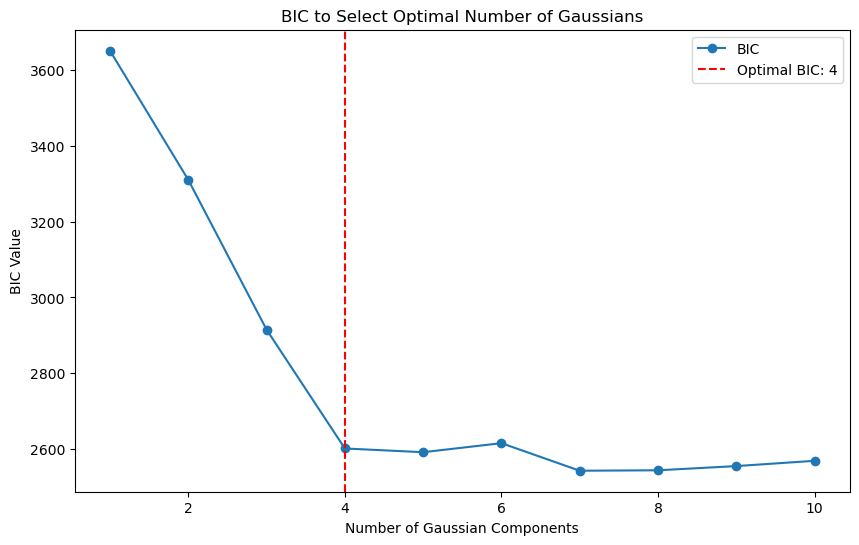

The optimal number of Gaussian components: 4


In [17]:
from sklearn.mixture import GaussianMixture

# Set a mximum number of onsets
n_max_gaussians = 10

# Prepare the 1D onsets data to the right configuration
onsets_ = np.expand_dims(conc_onsets, axis=1)

# Store BIC values
bic_values = []

# Fit GMMs with different numbers of components
for n_components in range(1, n_max_gaussians + 1):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(onsets_)
    bic_values.append(gmm.bic(onsets_))


# Find the optimal number of components using the elbow method,
#  stopping once the addition of a gaussian improves BIC in less than 10% of the last step.
optimal_components = find_elbow(bic_values, threshold=0.10)

# Plot BIC and AIC values
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_max_gaussians + 1), bic_values, label='BIC', marker='o')
plt.axvline(optimal_components, color='r', linestyle='--', label=f'Optimal BIC: {optimal_components}')
plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC Value")
plt.title("BIC to Select Optimal Number of Gaussians")
plt.legend()
plt.show()

print(f'The optimal number of Gaussian components: {optimal_components}')


In [18]:
# Train a GMM with the optimal number of components we found:
gmm = GaussianMixture(n_components=optimal_components, random_state=42,tol=1e-6)
gmm.fit(onsets_)

# Predict labels (classify):
onsets_labels = gmm.predict(onsets_)

# Get the median onset from every class as a prediction:
predicted_onsets = []
for label in range(optimal_components):
    pred = int(np.median(onsets_[onsets_labels == label]))
    predicted_onsets.append(pred)

# Sort from lowest to highest
predicted_onsets = np.sort(predicted_onsets)

c:\Users\Idan\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


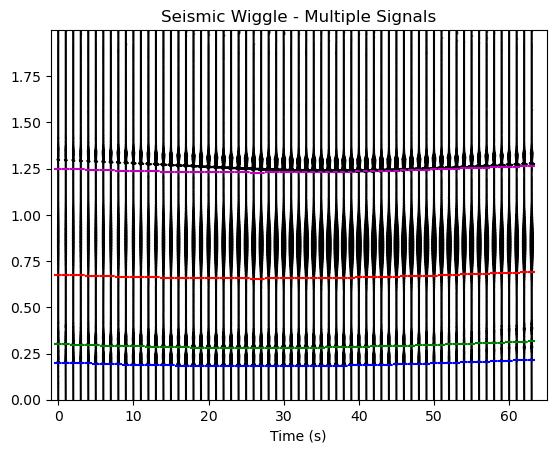

In [19]:
# Return to every signal's original time axis:
sensor_onsets = []
for i in range(n_sensors):
    sensor_onsets.append(predicted_onsets + lag_vec[i])

title = 'Seismic Wiggle - Multiple Signals'
fig = seismic_wiggle(data_norm, t_vec, picked_indices=sensor_onsets, title=title)



#### Discussion
From the results above I learn that the different occurrences are probably attributed to different source positions. In that case, the assumption we made earlier that the source is fixed, which allowed us to use a joint reference time-axis, is no longer valid. Unfortunately, I couldn't come up with a robust solution for calibrating the sensor time-axes. (cross-correlation works partially when the signals are perfect and is very sensitive to noise)
Nevertheless, the statistical approach I propose in Q.4 allows for a good approximation for picking synchroniously across all sensors, and most importantly, manages to capture the main occurences in the signals!

### Appendix
Here I include some additional results, namely, onset picking the seismograms using each method 
method under the influence of noise:

Starting with method 1 (pulse detection):

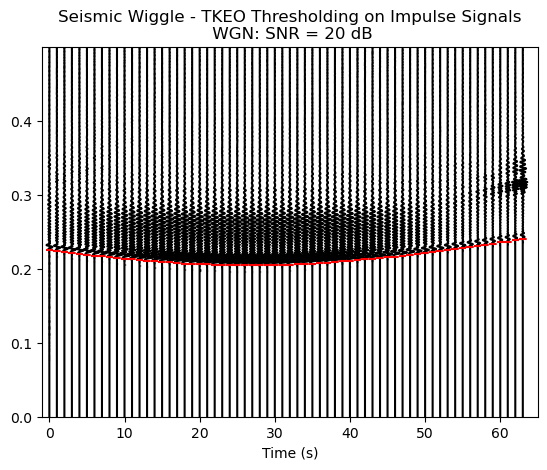

In [20]:
snr_dB= 20
data, fs, geometry = load_data(paths['data_sim_ricker'])
data.shape
geometry.shape
n_sensors, n_samples = data.shape
t_vec = np.arange(0,n_samples) / fs

normalization_fac = np.abs(data).max()
data_norm = data / normalization_fac

noisy = add_noise(data_norm,snr_dB,fs,noise_type='WGN')

# Find onsets with tkeo
onset_times, onset_indices = find_earliest_occurrences_with_tkeo_impulse(noisy, fs, peak_thresh_dB=20)

normalized_indices = np.array(onset_indices) - lag_vec

# Pick the onset using median on all estimated onsets (in the reference time-axis):
picked_idx_reference = np.median(normalized_indices)

# Return to each signal's original time-axis
picked_indices = picked_idx_reference + lag_vec

# Plot a seismic wiggle figure with the synchroniously picked onsets:

t_vec = np.arange(0, n_samples)/fs
title = 'Seismic Wiggle - TKEO Thresholding on Impulse Signals\n WGN: SNR = 20 dB'
fig = seismic_wiggle(data_norm, t_vec, picked_indices=picked_indices, title=title)



And ending with the second method 2 (continuous detection)

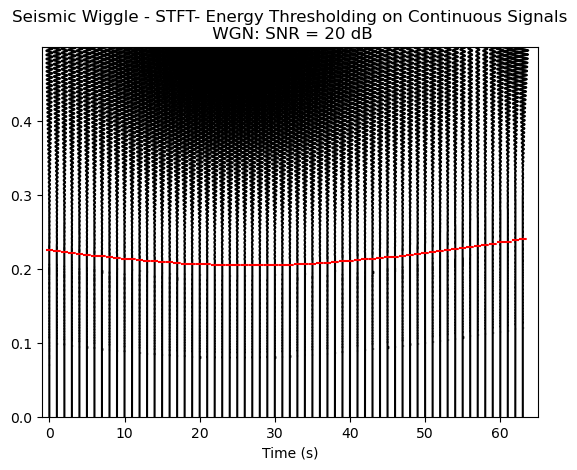

In [21]:
snr_dB= 20
data, fs, geometry = load_data(paths['data_sim_cont'])
data.shape
geometry.shape
n_sensors, n_samples = data.shape
t_vec = np.arange(0,n_samples) / fs

normalization_fac = np.abs(data).max()
data_norm = data / normalization_fac

# data_baseline
data_extended, t_vec_new, baseline_samples, baseline_indices =\
      prep_baseline(data_norm, fs, extend_duration=3)

noisy = add_noise(data_extended,snr_dB,fs,noise_type='WGN')

# Find onsets with stft energy thresholding
onset_bin_idx, onset_time = find_earliest_occurrences_stft_energy_thresh(sig, fs, baseline_indices, window='hann',
                                                    window_sz=128, frame_jump=16, peak_thresh_dB=60, noise_floor_factor=20)


normalized_indices = np.array(onset_indices) - lag_vec

# Pick the onset using median on all estimated onsets (in the reference time-axis):
picked_idx_reference = np.median(normalized_indices)

# Return to each signal's original time-axis
picked_indices = picked_idx_reference + lag_vec

# Plot a seismic wiggle figure with the synchroniously picked onsets:

t_vec = np.arange(0, n_samples)/fs
title = 'Seismic Wiggle - STFT- Energy Thresholding on Continuous Signals\n WGN: SNR = 20 dB'
fig = seismic_wiggle(data_norm, t_vec, picked_indices=picked_indices, title=title)

